In [229]:
import treex
import jax
import jax.numpy as jnp
import numpy as np
from skimage import data
import matplotlib.pyplot as plt
from einops import repeat

In [230]:
img = data.astronaut()

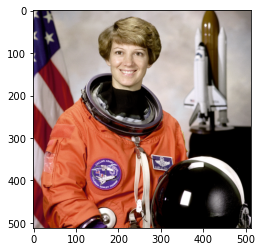

In [231]:
fig, ax = plt.subplots()

ax.imshow(img)

plt.show()

### Reshape

In [232]:
def squeeze(x, factor=2):
    assert x.ndim == 4
    b, h, w, c = x.shape
    
    assert h % factor == 0
    assert w % factor == 0
    
    x = jnp.reshape(x, (b, h//factor, factor, w//factor, factor, c))
    x = jnp.transpose(x, axes=(0, 1, 3, 5, 2, 4))
    x = jnp.reshape(x, (b, h//factor, w//factor, c * factor **2))
    
    return x

def unsqueeze(x, factor=2):
    assert x.ndim == 4
    b, h, w, c = x.shape
    
    x = jnp.reshape(x, (b, h, w, c // factor ** 2, factor, factor))
    x = jnp.transpose(x, axes=(0, 1, 4, 2, 5, 3))
    x = jnp.reshape(x, (b, h*factor, w*factor, c // factor ** 2))
    return x

In [233]:
x = repeat(img, "... -> 1 ...")
img_squeeze = squeeze(x)
img_squeeze.shape

x_orig = unsqueeze(img_squeeze)

np.testing.assert_array_equal(x, x_orig)

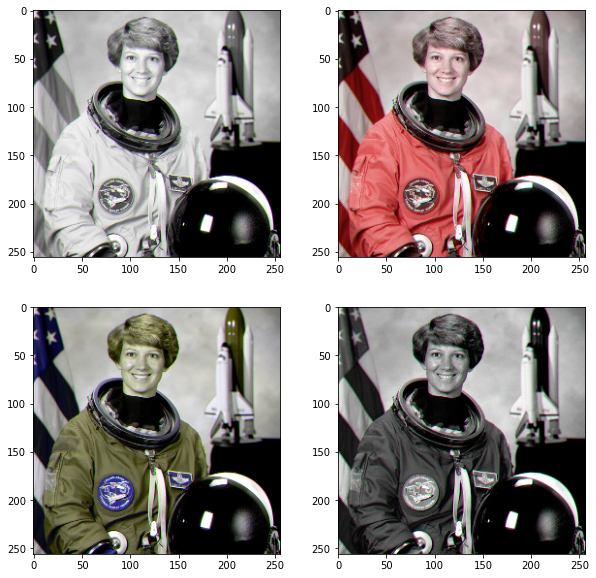

In [234]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

axs[0, 0].imshow(img_squeeze[0, ..., :3])
axs[0, 1].imshow(img_squeeze[0, ..., 3:6])
axs[1, 0].imshow(img_squeeze[0, ..., 6:9])
axs[1, 1].imshow(img_squeeze[0, ..., 9:12])
plt.show()

## DownSample

In [224]:
b, h, w, c = x.shape

kernel = np.ones((4, 1, 2, 2))
kernel[1, 0, 0, 1] = -1
kernel[1, 0, 1, 1] = -1

kernel[2, 0, 1, 0] = -1
kernel[2, 0, 1, 1] = -1

kernel[3, 0, 1, 0] = -1
kernel[3, 0, 0, 1] = -1


kernel = np.concatenate([kernel] * 3, 0).astype(np.float32)
# kernel = jnp.asarray(kernel).transpose([1, 2, 3, 0])
kernel = jnp.asarray(kernel).transpose([1,0,2,3])
kernel.shape

(1, 12, 2, 2)

In [225]:
print(img.shape)
x_torch = x.transpose([0, 3, 1, 2]).astype(jnp.float32)
x_torch.shape

(512, 512, 3)


(1, 3, 512, 512)

out shape:  (1, 200, 200, 3)  <-- original shape
Original Image:


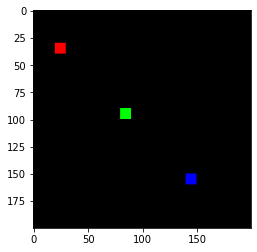

In [226]:
# NHWC layout
img = jnp.zeros((1, 200, 200, 3), dtype=jnp.float32)
for k in range(3):
  x = 30 + 60*k
  y = 20 + 60*k
  img = img.at[0, x:x+10, y:y+10, k].set(1.0)

print("out shape: ", img.shape, " <-- original shape")
print("Original Image:")
plt.imshow(img[0]);

In [208]:
img[0].min(), img[1].max()

(DeviceArray(0., dtype=float32), DeviceArray(1., dtype=float32))

Edge Conv kernel:


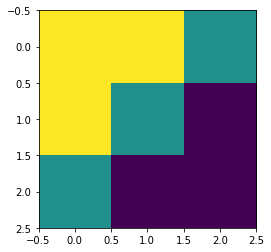

In [209]:
# 2D kernel - HWIO layout
kernel = jnp.zeros((3, 3, 3, 3), dtype=jnp.float32)
kernel += jnp.array([[1, 1, 0],
                     [1, 0,-1],
                     [0,-1,-1]])[:, :, jnp.newaxis, jnp.newaxis]

print("Edge Conv kernel:")
plt.imshow(kernel[:, :, 0, 0]);

In [210]:
dn = lax.conv_dimension_numbers(img.shape,     # only ndim matters, not shape
                                kernel.shape,  # only ndim matters, not shape 
                                ('NHWC', 'HWIO', 'NHWC'))  # the important bit
print(dn)

ConvDimensionNumbers(lhs_spec=(0, 3, 1, 2), rhs_spec=(3, 2, 0, 1), out_spec=(0, 3, 1, 2))


out shape:  (1, 100, 100, 3)  <-- half the size of above
First output channel:


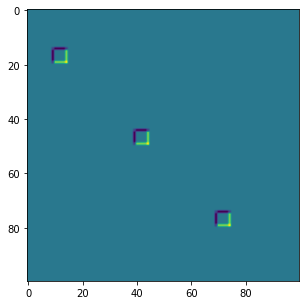

In [211]:
out = lax.conv_general_dilated(img,    # lhs = image tensor
                               kernel, # rhs = conv kernel tensor
                               (2,2),  # window strides
                               'SAME', # padding mode
                               (1,1),  # lhs/image dilation
                               (1,1),  # rhs/kernel dilation
                               dn)     # dimension_numbers = lhs, rhs, out dimension permutation
print("out shape: ", out.shape, " <-- half the size of above")
plt.figure(figsize=(5,5))
print("First output channel:")
plt.imshow(np.array(out)[0,:,:,0]);

In [212]:
out.min(), out.max()

(DeviceArray(-2., dtype=float32), DeviceArray(3., dtype=float32))

### Transpose

In [216]:
kernel.shape

(3, 3, 3, 3)

out shape:  (1, 200, 200, 3) <-- larger than original!
First output channel:
Original Image:


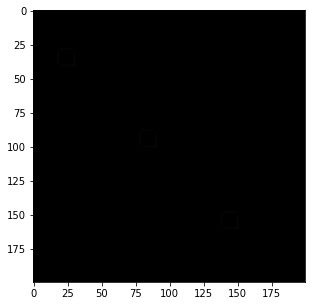

In [214]:
# The following is equivalent to tensorflow:
# N,H,W,C = img.shape
# out = tf.nn.conv2d_transpose(img, kernel, (N,2*H,2*W,C), (1,2,2,1))

# transposed conv = 180deg kernel roation plus LHS dilation
# rotate kernel 180deg:
kernel_rot = kernel#jnp.rot90(jnp.rot90(kernel, axes=(0,1)), axes=(0,1))
# need a custom output padding:
padding = ((2, 1), (2, 1))

img_ori = lax.conv_general_dilated(out,               # lhs = image tensor
                               kernel,            # rhs = conv kernel tensor
                               (1,1),             # window strides
                               padding,  # padding mode
                               (2,2),             # lhs/image dilation
                               (1,1),             # rhs/kernel dilation
                               dn)                # dimension_numbers = lhs, rhs, out dimension permutation
print("out shape: ", img_ori.shape, "<-- larger than original!")
plt.figure(figsize=(5,5))
print("First output channel:")
print("Original Image:")
plt.imshow(img_ori[0].astype(np.uint8));

In [215]:
img_ori.min(), img_ori.max()

(DeviceArray(-12., dtype=float32), DeviceArray(9., dtype=float32))

In [206]:
img_ori[0].min(), img_ori[0].max(), img[0].min(), img[0].max()

(DeviceArray(-12., dtype=float32),
 DeviceArray(9., dtype=float32),
 DeviceArray(0., dtype=float32),
 DeviceArray(1., dtype=float32))

In [375]:
img_ori.shape
from einops import rearrange

In [376]:
b, h, w, c = x.shape

kernel = np.ones((4, 1, 2, 2))
kernel[1, 0, 0, 1] = -1
kernel[1, 0, 1, 1] = -1

kernel[2, 0, 1, 0] = -1
kernel[2, 0, 1, 1] = -1

kernel[3, 0, 1, 0] = -1
kernel[3, 0, 0, 1] = -1
kernel *= 0.5

kernel = np.concatenate([kernel] * 3, 0)
# kernel = jnp.asarray(kernel).transpose([1, 2, 3, 0])
# kernel = jnp.asarray(kernel).transpose([1,0,2,3])
# kernel = repeat(kernel, "A 1 B C -> A 3 B C")
kernel = kernel.astype(np.float32)
kernel.shape

(12, 1, 2, 2)

In [365]:
print(img.shape)
x_torch = x.transpose([0, 3, 1, 2]).astype(jnp.float32)
x_torch.shape

(512, 512, 3)


(1, 3, 512, 512)

In [379]:
from jax import lax

dn = lax.conv_dimension_numbers(
    x.shape,     # only ndim matters, not shape
    kernel.shape,  # only ndim matters, not shape 
    ('NCHW', 'OIHW', 'NCHW'),
)  # the important bit
print(dn)

ConvDimensionNumbers(lhs_spec=(0, 1, 2, 3), rhs_spec=(0, 1, 2, 3), out_spec=(0, 1, 2, 3))


In [380]:
x_torch.shape, kernel.shape

((1, 3, 512, 512), (12, 1, 2, 2))

In [381]:
x_squeezed = lax.conv(
    lhs=x_torch,    # lhs = image tensor
    rhs=kernel, # rhs = conv kernel tensor
    window_strides=(2,2),  # window strides
    padding='SAME', # padding mode

)     # dimension_numbers = lhs, rhs, out dimension permutation

ValueError: conv_general_dilated lhs feature dimension size divided by feature_group_count must equal the rhs input feature dimension size, but 3 // 1 != 1.

In [369]:
x_squeezed.shape

(1, 12, 256, 256)

In [336]:
x_squeezed = lax.conv_general_dilated(
    lhs=x_torch,    # lhs = image tensor
    rhs=kernel, # rhs = conv kernel tensor
    window_strides=(2,2),  # window strides
    padding='SAME', # padding mode
    lhs_dilation=(1,1),  # lhs/image dilation
    rhs_dilation=(1,1),  # rhs/kernel dilation
    dimension_numbers=dn,
    feature_group_count=3
)     # dimension_numbers = lhs, rhs, out dimension permutation

In [371]:
x_squeezed.min(), x_squeezed.max()

(DeviceArray(-601.5, dtype=float32), DeviceArray(1528.5, dtype=float32))

In [382]:
from sklearn.preprocessing import MinMaxScaler

In [385]:
x_squeezed = MinMaxScaler((0., 255.)).fit_transform(x_squeezed.ravel()[:, None]).ravel()
x_squeezed = x_squeezed.reshape((1, 12, 256, 256))

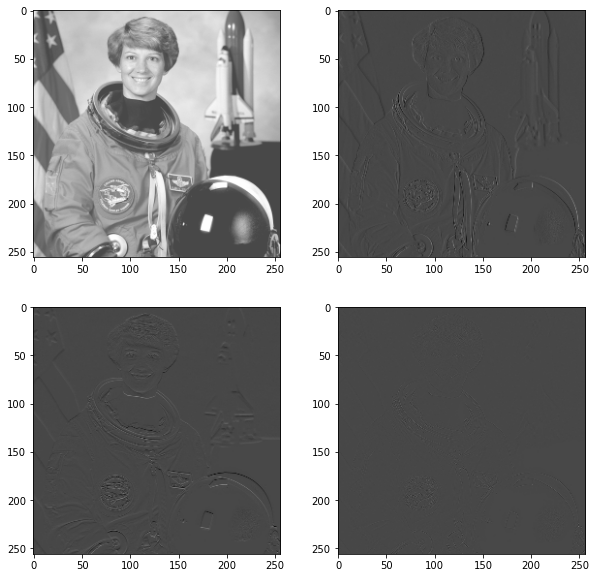

In [386]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

axs[0, 0].imshow(x_squeezed[0, 0::4, ...].transpose([1,2,0]).astype(np.uint8))
axs[0, 1].imshow(x_squeezed[0, 1::4, ...].transpose([1,2,0]).astype(np.uint8))
axs[1, 0].imshow(x_squeezed[0, 2::4, ...].transpose([1,2,0]).astype(np.uint8))
axs[1, 1].imshow(x_squeezed[0, 3::4, ...].transpose([1,2,0]).astype(np.uint8))
plt.show()

In [318]:
x_torch.shape, x_squeezed.shape, 

((1, 3, 512, 512), (1, 12, 256, 256))

In [319]:
kernel.shape, kernel.transpose([1, 0, 2, 3]).shape

((12, 1, 2, 2), (1, 12, 2, 2))

In [320]:
# np.testing.assert_array_equal(kernel_rot, kernel.transpose([1, 0, 2, 3]))

In [328]:
dn = lax.conv_dimension_numbers(
    x.shape,     # only ndim matters, not shape
    kernel.shape,  # only ndim matters, not shape 
    ('NCHW', 'OIHW', 'NCHW'),
)  # the important bit
print(dn)

# kernel_rot = jnp.rot90(jnp.rot90(kernel, axes=(2,3)), axes=(2,3))
padding = ((1, 1), (1, 1))
# padding = "SAME"
x_torch_ori = lax.conv_general_dilated(
    lhs=x_squeezed,    # lhs = image tensor
    rhs=kernel, # rhs = conv kernel tensor
    window_strides=(1,1),  # window strides
    padding=padding, # padding mode
    lhs_dilation=(2,2),  # lhs/image dilation
    rhs_dilation=(1,1),  # rhs/kernel dilation
    dimension_numbers=dn,
    feature_group_count=3
)     # dimension_numbers = lhs, rhs, out dimension permutation

# x_torch_ori = lax.conv_general_dilated(
#     lhs=x_squeezed,    # lhs = image tensor
#     rhs=kernel, # rhs = conv kernel tensor
#     window_strides=(1,1),  # window strides
#     padding=((0, 0), (0, 0)), # padding mode
#     lhs_dilation=(2,2),  # lhs/image dilation
#     rhs_dilation=(1,1),  # rhs/kernel dilation
#     dimension_numbers=dn,
#     feature_group_count=3
# )     # dimension_numbers = lhs, rhs, out dimension permutation

ConvDimensionNumbers(lhs_spec=(0, 1, 2, 3), rhs_spec=(0, 1, 2, 3), out_spec=(0, 1, 2, 3))


ValueError: conv_general_dilated lhs feature dimension size divided by feature_group_count must equal the rhs input feature dimension size, but 12 // 3 != 1.

In [326]:
x_torch_ori.shape, 

((1, 1, 512, 512),)

In [327]:
x_torch.min(), x_torch.max(), x_torch_ori.min(), x_torch_ori.max()

(0.0, 255.0, DeviceArray(0., dtype=float32), DeviceArray(3060., dtype=float32))

TypeError: Invalid shape (512, 512, 12) for image data

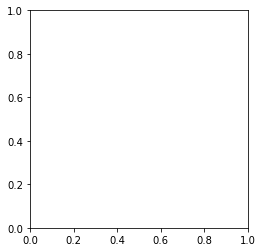

In [262]:
fig, ax = plt.subplots()

ax.imshow(x_torch_ori.squeeze().transpose([1,2,0]))

plt.show()

In [243]:
x_torch_ori.shape

(1, 12, 513, 513)

In [126]:
out_inv = lax.conv_transpose(
    out,    # lhs = image tensor
    kernel, # rhs = conv kernel tensor
    strides=(2,2),  # window strides
    padding='SAME', # padding mode
    rhs_dilation=(1,1),  # lhs/image dilation
    dimension_numbers=dn,
)     # dimension_numbers = lhs, rhs, out dimension permutation
out_inv.shape

ValueError: conv_general_dilated lhs feature dimension size divided by feature_group_count must equal the rhs input feature dimension size, but 12 // 1 != 1.

In [100]:
out = lax.conv(
    lhs=x_torch, # lhs = NCHW image tensor
    rhs=kernel, # rhs = OIHW conv kernel tensor
    window_strides=(1, 1),  # window strides
    padding='SAME',
    # dn
) # padding mode

ValueError: conv_general_dilated lhs feature dimension size divided by feature_group_count must equal the rhs input feature dimension size, but 3 // 1 != 12.